# Example data to help for parallel development

A full week of methane emission plume detection examples is provided with all intermediate results to help group members to develop their contributions independently. For 43 methane emission plumes, the official satellite data product has been cropped into small convenient datasets enabling to develop in parallel:
+ the meteo data download function
+ the plume masking function
+ the emission quantification function


In [153]:
# useful libraries
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Task: download meteorological data

The student developing the function that downloads meteo data can use the lat,lon,date,time from `df` as input to their function

# Looking into example files

In [ ]:
# let's read an example data file
##############################
# first let's select and index

# build file name
example_file = '\\Users\\Mon PC\\Documents\\Projet-info\\example_data\\data\\example_data_3.nc'

# read the file
ds = xr.open_dataset(example_file)

# look into the dataset
ds

<xarray.Dataset> Size: 160kB
Dimensions:                                        (scanline: 50,
                                                    ground_pixel: 35, corner: 4)
Coordinates:
    time                                           datetime64[ns] 8B ...
    latitude                                       (scanline, ground_pixel) float32 7kB ...
    longitude                                      (scanline, ground_pixel) float32 7kB ...
    orbit                                          int32 4B ...
  * scanline                                       (scanline) float64 400B 1....
  * ground_pixel                                   (ground_pixel) float64 280B ...
  * corner                                         (corner) float64 32B 0.0 ....
Data variables: (12/14)
    time_utc                                       (scanline) <U27 5kB ...
    qa_value                                       (scanline, ground_pixel) float32 7kB ...
    methane_mixing_ratio_precision                 (scanline, ground_pixel) float32 7kB ...
    methane_mixing_ratio_bias_corrected            (scanline, ground_pixel) float32 7kB ...
    latitude_bounds                                (corner, scanline, ground_pixel) float32 28kB ...
    longitude_bounds                               (corner, scanline, ground_pixel) float32 28kB ...
    ...                                             ...
    eastward_wind                                  (scanline, ground_pixel) float32 7kB ...
    northward_wind                                 (scanline, ground_pixel) float32 7kB ...
    surface_pressure                               (scanline, ground_pixel) float32 7kB ...
    cloud_fraction_VIIRS_SWIR_IFOV                 (scanline, ground_pixel) float32 7kB ...
    methane_mixing_ratio_bias_corrected_destriped  (scanline, ground_pixel) float32 7kB ...
    SRON_plume_mask                                (scanline, ground_pixel) float64 14kB ...
Attributes:
    SRON plume source lat,lon:       [-23.27 148.89]
    SRON plume source rate t_per_h:  12
    SRON plume uncertainty t_per_h:  5
    SRON URL:                        https://ftp.sron.nl/pub/memo/CSVs/

In [94]:
ds["eastward_wind"].mean()


<xarray.DataArray 'eastward_wind' ()> Size: 8B
array(2.36167359)
Coordinates:
    time     datetime64[ns] 8B ...
    orbit    int32 4B ...

# Task: identifying the methane emission plume in the example data

The student developing the function to mask the plume can use the `methane_mixing_ratio_bias_corrected_destriped` data variable to develop their function. A solution obtained using the SRON machine-learning based detection framework is provided for example in the variable `SRON_plume_mask`. THIS IS NOT THE ONLY SOLUTION, JUST A GOOD ONE.

Masking the plume basically consists in selecting high methane concentration pixels in the vicinity of an emission source. The emission source is provided in the csv files (lat,lon) and in the dataset attributes (`SRON plume source lat,lon`). The article by Schuit et al. (2023) provides an approach based on an iterative mask dilation starting from a source pixel (Section 2.3).

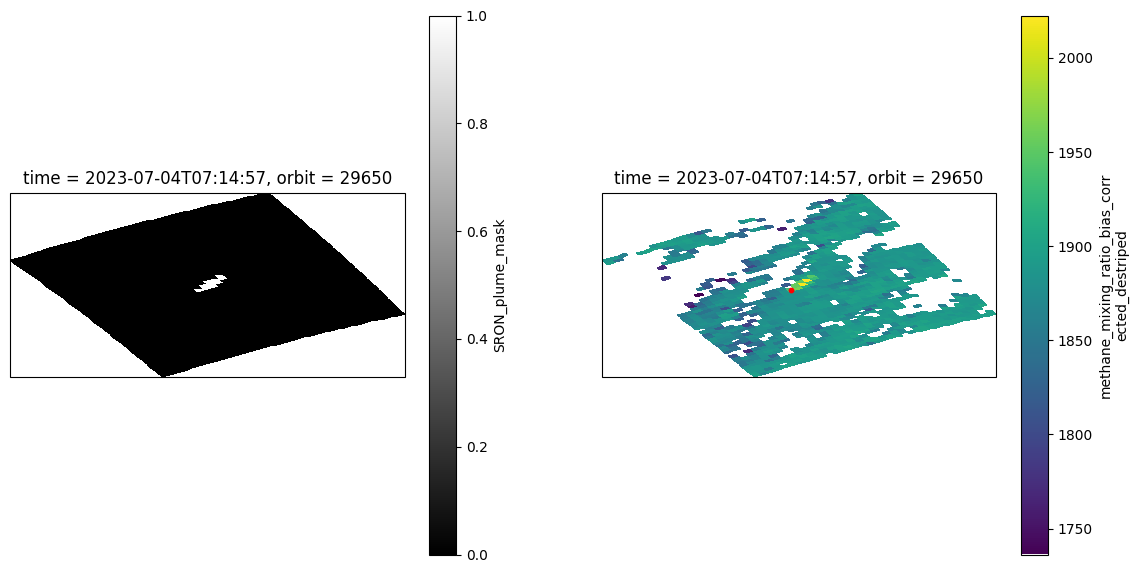

In [95]:
# Let's plot these variables

fig = plt.figure(figsize=(14,7))

# plume mask
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ds.SRON_plume_mask.plot(x='longitude',
                        y='latitude',
                        cmap='binary_r',
                       vmin=0,
                       vmax=1,
                       transform=ccrs.PlateCarree())

# methane data
ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ds.methane_mixing_ratio_bias_corrected_destriped.plot(x='longitude',
                        y='latitude',
                        cmap='viridis',
                       transform=ccrs.PlateCarree())
# add the source as a red dot
ax.scatter([ds.attrs['SRON plume source lat,lon'].data[1]],
            [ds.attrs['SRON plume source lat,lon'].data[0]],
           transform=ccrs.PlateCarree(),
           marker='o',
           s=10,
           color='red')

# we see that mask==1 corresponds to higher methane concentration

# Task: quantifying the methane emission rate

The method to implement is called the Integrated Mass Enhancement (IME). It is explained in Section 2.5.1 in the paper by Schuit et al. (2023). Inputs to this calculation are provided in the example files:
+ The lat,lon corner coordinates to compute the area of each pixel (use the haversine distance to have distances in meters from coordinates in lat,lon on the sphere): `latitude_bounds`, `longitude_bounds`
+ The methane concentration field: `methane_mixing_ratio_bias_corrected_destriped`
+ The identified methane emission plume: `SRON_plume_mask`
+ Eastern and Northern components of wind speed: `eastward_wind`, `northward_wind`
+ The surface pressure to compute the number of molecules in the total atmospheric column: `surface_pressure`

Using surface pressure and wind speed data coming from different meteorological models can help evaluate an uncertainty to this quantification. The plume masking parameters, and the uncertainty on the methane data (data variable `methane_mixing_ratio_precision`) can also be included in the uncertainty evaluation


In [159]:
import xarray as xr
import numpy as np

'''Open the file and build the dataset'''

# build file name

ic = 3

data_file = '\\Users\\Mon PC\\Documents\\Projet-info\\example_data\\data\\example_data_'+'%d'%ic+'.nc'

# read the file
ds = xr.open_dataset(data_file) 

In [160]:

''' NEED FOR : 

ds that contains at least the following variables:
    - methane_mixing_ratio_bias_corrected_destriped
    - surface_pressure
    - northward_wind
    - eastward_wind
    
'''



''' Constant hyperparameters '''

M_CH4 = 16.04 # Molar mass of methane in g/mol
M_air = 28.97 # Molar mass of air in g/mol

g = 9.81 # Acceleration due to gravity in m/s^2

A = 5000*7500 # Area of one pixel in m^2
R = 6378000 # Radius of the Earth in meters

'''Some useful functions to calculate the area of a pixel'''

def distance_harvesine(lat1d, lon1d, lat2d, lon2d):
    """
    Calculate the distance between two points on the Earth using the Haversine formula.
    """
    lat1=lat1d*np.pi/180
    lat2=lat2d*np.pi/180
    lon1=lon1d*np.pi/180
    lon2=lon2d*np.pi/180

    return 2*R*np.arcsin(np.sqrt((np.sin((lat2-lat1)/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon2 - lon1)/2))**2))

vdistance_harvesine = np.vectorize(distance_harvesine)

def area_calculation(latitude_bounds, longitude_bounds):
    """
    Calculate the area of a pixel in square meters based on latitude and longitude.
    """

    lat1 = latitude_bounds[0,:,:]
    lon1 = longitude_bounds[0,:,:]
    lat2 = latitude_bounds[1,:,:]
    lon2 = longitude_bounds[1,:,:]
    lat3 = latitude_bounds[2,:,:]
    lon3 = longitude_bounds[2,:,:]

    return vdistance_harvesine(lat1, lon1, lat2, lon2) * vdistance_harvesine(lat2, lon2, lat3, lon3)

ds['pixel_area'] = ("scanline", "ground_pixel"), area_calculation(ds.latitude_bounds, ds.longitude_bounds)



# Calculate the area of each pixel in the dataset
# This will create a new variable 'pixel_area' in the dataset

''' Non-constant hyperparameters '''

alpha_1 = 0.5 # Coefficient for wind speed calculation

METHANE_COL = "methane_mixing_ratio_bias_corrected_destriped"
FACTOR = 1.25


'''Let's build the mask'''

def is_plume(methane, moy, std):
    return (methane > (moy + FACTOR * std))


moy, std = ds[METHANE_COL].mean(), ds[METHANE_COL].std()
ds["plume_belonging"] = xr.apply_ufunc(is_plume, ds.methane_mixing_ratio_bias_corrected_destriped, moy, std)



'''Area of the plume'''

Plume_area_1 = (ds.plume_belonging).sum()*A # Area of the plume in m^2

Plume_area_2 = (ds.plume_belonging*ds.pixel_area).sum() # Area of the plume in m^2

print("Plume area A constant: ", Plume_area_1.data, "m^2")
print("Plume area A variable: ", Plume_area_2.data, "m^2")

'''Let's calculate the wind speed'''

def wind_speed():

    '''Calculate wind speed from 10m wind data.'''
    
    out = alpha_1*(ds.northward_wind**(2) + ds.eastward_wind**(2))**(1/2)
    return out

ds['wind_speed'] = xr.apply_ufunc(wind_speed)# first function name
                                    

'''Let's calculate the emission rate'''

mask = ds.plume_belonging
concentration_rate_mean_ppb = ds.methane_mixing_ratio_bias_corrected_destriped.where(~mask).mean() # Mean methane concentration in the scene without the plume in tons
wind_speed_mean = ds.wind_speed.where(mask).mean()*(3.6*1e3) # Mean wind speed in the plume in m/h


print("The concentration mean en ppb is", concentration_rate_mean_ppb.data)

Q = ((wind_speed_mean)/(np.sqrt(Plume_area_2)))*(ds.pixel_area.where(mask)*ds.surface_pressure.where(mask)*(ds.methane_mixing_ratio_bias_corrected_destriped.where(mask) - concentration_rate_mean_ppb)).sum()*1e-9*M_CH4*1e-3/(g*M_air) # Emission rate in tons/hour

print ("The emission rate is", Q.data)



Plume area A constant:  -807467296 m^2
Plume area A variable:  4248732756.587907 m^2
The concentration mean en ppb is 1868.7598876953125
The emission rate is 29.332173326801808


In [161]:
''' NEED FOR : 

ds that contains at least the following variables:
    - methane_mixing_ratio_bias_corrected_destriped
    - surface_pressure
    - northward_wind
    - eastward_wind

'''


import random as rd

FACTOR_MIN = 1.3 # Minimum factor for plume belonging
FACTOR_MAX = 2.3 # Maximum factor

alpha_1_min = 0.5*(1 - 0.05) # Minimum coefficient for wind speed calculation
alpha_1_max = 0.5*(1 + 0.05) # Maximum Coefficient for wind speed calculation

wind_speed_max = ds.wind_speed.mean() + ds.wind_speed.std()# Minimum wind speed in the entire scene
wind_speed_min = ds.wind_speed.mean() - ds.wind_speed.std()# Maximum wind speed in the entire scene

pressure_std = ds.surface_pressure.std() # Standard deviation of surface pressure in the entire scene
methane_std = ds.methane_mixing_ratio_bias_corrected_destriped.std() # Standard deviation of methane mixing ratio in the entire scene

def is_plume_rd(methane, moy, std):
    return (methane > (moy + FACTOR_rd * std))

Q_liste = np.array([])

#Let's calculate the emission rate with random parameters

for i in range(100): # 100 random samples

    FACTOR_rd = rd.uniform(FACTOR_MIN, FACTOR_MAX) # Random factor for plume belonging

    ds["plume_belonging_rd"] = xr.apply_ufunc(is_plume_rd, ds.methane_mixing_ratio_bias_corrected_destriped, moy, std) #Creation of the plume mask with random factor

    Plume_area_rd = (ds.pixel_area*ds.plume_belonging_rd).sum() # Area of the plume in m^2

    alpha_1_rd = rd.uniform(alpha_1_min, alpha_1_max) # Random coefficient for wind speed calculation

    wind_speed_rd = rd.uniform(wind_speed_min, wind_speed_max)*(3.6*1e3) # Random wind speed in the plume in m/h
    mask = ds.plume_belonging_rd

    # Now we can calculate the emission rate

    Q_liste = np.append(Q_liste, 
                        (alpha_1_rd*wind_speed_rd) # Random wind speed in m/h
                        /
                        (np.sqrt(Plume_area_rd)) #Random plume area in m^2
                        *
                        (ds.pixel_area.where(mask)
                         *
                         rd.uniform(ds.surface_pressure.where(mask) - pressure_std,
                               ds.surface_pressure.where(mask) + pressure_std) # Random surface pressure in Pa
                               *
                               (rd.uniform(ds[METHANE_COL].where(mask) - 2*methane_std, 
                               ds[METHANE_COL].where(mask) + 2*methane_std) # Random methane mixing ratio
                                - concentration_rate_mean_ppb)
                               ).sum()*1e-9*M_CH4*1e-3/(g*M_air)) # Emission rate in tons/hour

print("Emission rate mean: ", np.mean(Q_liste),"+/-", np.std(Q_liste), "t/h")

Emission rate mean:  16.226818664502517 +/- 7.475635754413162 t/h


In [162]:
nan_count = np.isnan(Q_liste).sum()
print(nan_count)

0
